In [1]:
import pypsa
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
originalDataSet = pypsa.Network("Problemset/input.nc")
processedDataSet = pypsa.Network("Problemset/output.nc")

/mnt/c/Users/d60098/Documents/PlanQK/energy/DockerUseCase/venv/lib/python3.8/site-packages/pypsa/io.py:769: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  pnl[attr] = pnl[attr].reindex(columns=df.index | columns, fill_value=default)
/mnt/c/Users/d60098/Documents/PlanQK/energy/DockerUseCase/venv/lib/python3.8/site-packages/pypsa/io.py:771: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  pnl[attr] = pnl[attr].reindex(columns=(pnl[attr].columns | columns))
INFO:pypsa.io:Imported network input.nc has buses, generators, lines, loads
INFO:pypsa.io:Imported network output.nc has buses, generators, lines, loads


# Helper tools for visualization

In [19]:
#@title
def printCommitedGenerators(network):
  total = 0
  for name in network.generators_t.status:
    a = sum(network.generators_t.status[name])
    total += a
    print(f"Generator {name} is online for {a} snapshots.")
  print(f"Total commited generators: {total}")


def checkExtraConstraints(network):
  """Checks if the unit commitment constraints are reflected in the generators power."""
  counter = 0
  for genName in network.generators_t.status:
    for timestamp in network.generators_t.status.index:
      if network.generators_t.status[genName][timestamp] == 0:
        if not network.generators_t.p[genName][timestamp] == 0:
          print(f"Constraint has been broken. {genName} at timestep {str(timestamp)}")
          counter += 1
  return counter


def isConstraintTFulfilled(network, generatorName, posT):
  if (network.generators_t.status[generatorName].iloc[posT-1] - network.generators_t.status[generatorName].iloc[posT] == 0):
    return True
  isDown = 1
  T = network.generators.min_down_time[generatorName]
  if (network.generators_t.status[generatorName].iloc[posT]):
    T = network.generators.min_up_time[generatorName]
    isDown = 0
  for i in range(1,T):
    t = posT + i
    if t >= len(network.snapshots):
      return True
    if(network.generators_t.status[generatorName].iloc[t] - isDown == 0):
      return False
  return True
    

def countInvalidatedT(network):
  counter = 0
  for gen in network.generators_t.status.columns:
    for time in range(1,len(network.snapshots)):
      if not isConstraintTFulfilled(network, gen, time):
        counter += 1
  print(f"The minup/mindown constraints are invalidated {counter} times.")
  return counter


def plotPowerOutput(network, startTime=None, endTime=None):
  if(startTime is None):
    startTime = 0
  if(endTime is None):
    endTime = len(network.snapshots) - 1
  keys = network.generators_t.status.columns
  cols = int(len(keys)/4) + min(len(keys)%4,1)
  fig, axes = plt.subplots(cols, 4, sharex=True)
  fig.set_size_inches(25, 22)
  for i in range(cols):
    for j in range(4):
      pos = i*4+j
      if pos < len(keys):
        genName = keys[pos]
        axes[i,j].plot(network.generators_t.status[genName].iloc[startTime : endTime]*network.generators.p_nom[genName])
        axes[i,j].plot(network.generators_t.p[genName].iloc[startTime : endTime])
        axes[i,j].set_title(genName)
      axes[i,j].tick_params(axis="x", labelrotation=90)
  plt.show()


def checkKirchhoffConstraint(network, snapshots):
  counter = 0
  for time in snapshots:
    for node in network.buses.index:
      total = 0
      #sum of storage power
      idx = network.storage_units[network.storage_units.bus == node].index
      total += network.storage_units_t.p[idx].loc[time].sum()
      # sum of generator power
      idx = network.generators[network.generators.bus == node].index
      total += network.generators_t.p[idx].loc[time].sum()
      # sum of loads
      total -= network.loads_t.p_set[node].loc[time].sum()
      # lines
      idx = network.lines[network.lines.bus0 == node].index
      total -= network.lines_t.p0[idx].loc[time].sum()
      idx = network.lines[network.lines.bus1 == node].index
      total -= network.lines_t.p1[idx].loc[time].sum()
      if (abs(total) > 0.001):
        counter += 1
  print(f"The Kirchhoff constraint has been violated {counter} times.")
  return counter

def plotCostOverIterations(costs):
  plt.plot(
      range(len(costs)),
      costs,
      label="Cost function over Iterations")
  plt.show()

def calculateMonetaryCost(network, networkExpansion=False):
  # general costs
  totalCosts = 0.
  if(networkExpansion):
    totalCosts += ((network.generators["p_nom_opt"] - network.generators["p_nom"]) * network.generators["capital_cost"]).sum()
    totalCosts += ((network.storage_units["p_nom_opt"] - network.storage_units["p_nom"]) * network.storage_units["capital_cost"]).sum()
    totalCosts += ((network.lines["s_nom_opt"] - network.lines["s_nom"]) * network.lines["capital_cost"]).sum()
  
  # time-dependent costs
  tmp = network.generators_t.p.transpose().multiply(
      network.snapshot_weightings
  ).transpose().sum()
  totalCosts += (tmp * network.generators["marginal_cost"]).sum()
  
  tmp = network.storage_units_t.p.transpose().multiply(
      network.snapshot_weightings
  ).transpose().sum()
  totalCosts += (tmp * network.storage_units["marginal_cost"]).sum()
  return totalCosts


def plotGenerationVSDemand(network):
  # Load timeseries per zone
  col=['b','c','g','m','y']
  lin = ['-','--','-.',':','-']
  fig, axes = plt.subplots(1,2)
  fig.set_size_inches(15, 7)
  for i, zone in enumerate(network.loads_t.p_set):
    axes[0].plot(network.loads_t.p_set[zone][:300], label = zone, marker='', color=col[i], linewidth=2, linestyle= lin[i])
    axes[0].legend(title="Visualize load timeseries per zone",
                   bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
                   ncol=2, mode="expand", borderaxespad=0.)
  axes[0].tick_params(axis="x", labelrotation=90)
  #Aggregate load timeseries over all zones
  totalLoad = network.loads_t.p_set.sum(axis=1)
  totalGen = network.generators_t.p.sum(axis=1)
  # Power generation timeseries & load timeseries aggregated over all zones
  axes[1].plot(totalLoad[:300], label = 'LOAD_ALL_ZONES',marker='', color='m', linewidth=3, linestyle= '--')
  axes[1].plot(totalGen[:300], label = 'GENERATOR_POWER_ALL_ZONES',marker='', color='b', linewidth=1, linestyle= '-')
  axes[1].legend(title="Generation and Load aggregated over all zones",
                   bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
                   ncol=2, mode="expand", borderaxespad=0.) 
  axes[1].tick_params(axis="x", labelrotation=90)
  plt.xticks(rotation='vertical') 
  plt.show()

  #Prepare representation of generation timeseries aggregated represented per zone
  df1 = network.generators['bus']
  df2 = network.generators_t.p.sum(axis=0)
  df2_transposed = network.generators_t.p.transpose()
  df3 = pd.concat([df1,df2], axis=1)
  df4 = pd.concat([df1,df2_transposed], axis=1)

  # aggregate generation power per node
  df_gen_ts_per_zone = df4.groupby(['bus']).sum().transpose()
  df_gen_total_per_zone = df4.groupby(['bus']).sum().transpose().sum(axis=0)
  df_gen_ts_total = df4.groupby(['bus']).sum().transpose().sum(axis=1)

  # Total power generation per zone - no timeseries
  print('Total power generation per zone - no timeseries:') 
  print(df_gen_total_per_zone)

  # Power generation timeseries power per zone
  for i, zone in enumerate(df_gen_ts_per_zone):
    plt.plot(df_gen_ts_per_zone[zone][:300],label = zone,marker='', color=col[i], linewidth=2, linestyle= lin[i])  #.drop(columns='summe')
    plt.xticks(rotation='vertical')
  plt.legend(title="Visualize power generation timeseries power per zone",
                   bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
                   ncol=2, mode="expand", borderaxespad=0.) 
  plt.show()

  # Visualize load timeseries & power generation timeseries per zone
  col=['c','c','c','c','c']
  lin = ['--','--','--','--','--']
  for i, zone in enumerate(df_gen_ts_per_zone):
    plt.plot(network.loads_t.p_set[zone][:300],label = zone,marker='', color='b', linewidth=2, linestyle= '-')  #.drop(columns='summe')
    plt.plot(df_gen_ts_per_zone[zone][:300],label = zone,marker='', color=col[i], linewidth=2, linestyle= lin[i])  #.drop(columns='summe')
  
  plt.xticks(rotation='vertical')  
  plt.legend(title="Load and power generation per zone",
                bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
                ncol=2, mode="expand", borderaxespad=0.) 
  plt.show()


def generateReport(network, snapshots=None, endTime = None):
  if(snapshots is None):
    snapshots = network.snapshots
  print(f"Total cost with network expansion: {calculateMonetaryCost(network,networkExpansion=True)}")
  print(f"Total cost without network expansion: {calculateMonetaryCost(network, networkExpansion=False)}")
  printCommitedGenerators(network)
  checkExtraConstraints(network)
  countInvalidatedT(network)
  checkKirchhoffConstraint(network, snapshots)
  plotGenerationVSDemand(network)
  plotPowerOutput(network, endTime=endTime)

In [20]:
test = processedDataSet.copy()

Total cost with network expansion: 2508542564.7198067
Total cost without network expansion: 1460279631.8298566
Generator DE0 0 CCGT is online for 729.0 snapshots.
Generator DE0 0 OCGT is online for 0.0 snapshots.
Generator DE0 0 coal is online for 744.0 snapshots.
Generator DE0 0 offwind-ac is online for 1.0 snapshots.
Generator DE0 0 offwind-dc is online for 1.0 snapshots.
Generator DE0 0 onwind is online for 1.0 snapshots.
Generator DE0 0 solar is online for 1.0 snapshots.
Generator DE0 1 CCGT is online for 744.0 snapshots.
Generator DE0 1 OCGT is online for 1.0 snapshots.
Generator DE0 1 coal is online for 744.0 snapshots.
Generator DE0 1 offwind-ac is online for 1.0 snapshots.
Generator DE0 1 offwind-dc is online for 1.0 snapshots.
Generator DE0 1 onwind is online for 1.0 snapshots.
Generator DE0 1 solar is online for 1.0 snapshots.
Generator DE0 2 CCGT is online for 732.0 snapshots.
Generator DE0 2 OCGT is online for 1.0 snapshots.
Generator DE0 2 coal is online for 744.0 snapshot

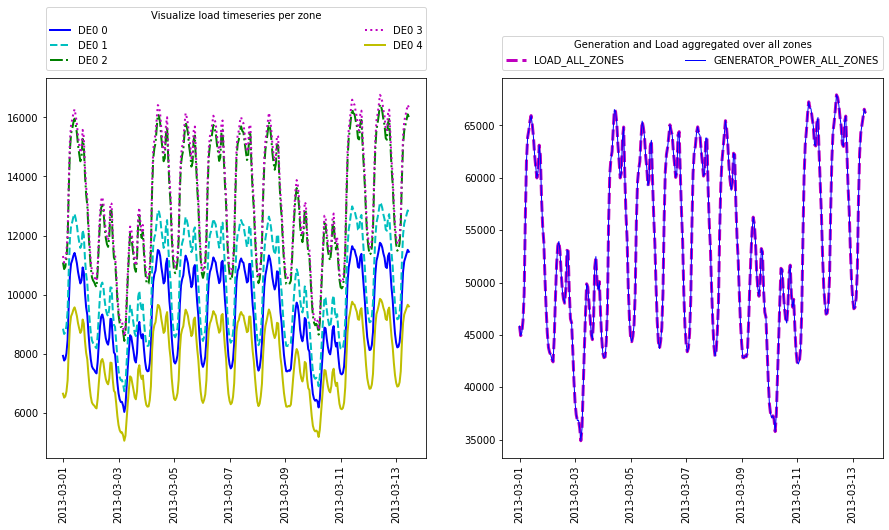

Total power generation per zone - no timeseries:
bus
DE0 0    8.284736e+06
DE0 1    1.388540e+07
DE0 2    4.497549e+06
DE0 3    1.045658e+07
DE0 4    2.607549e+06
dtype: float64


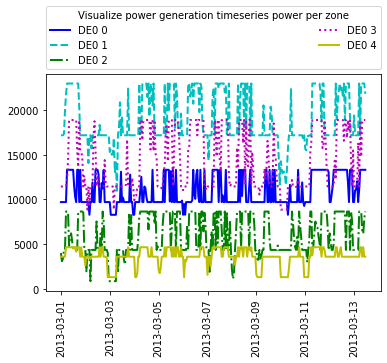

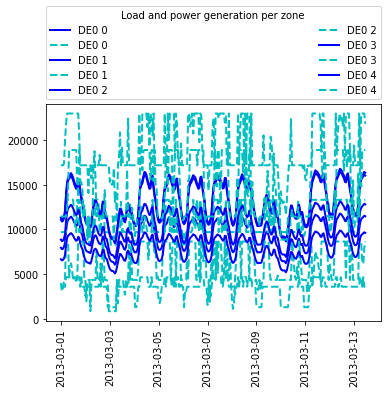

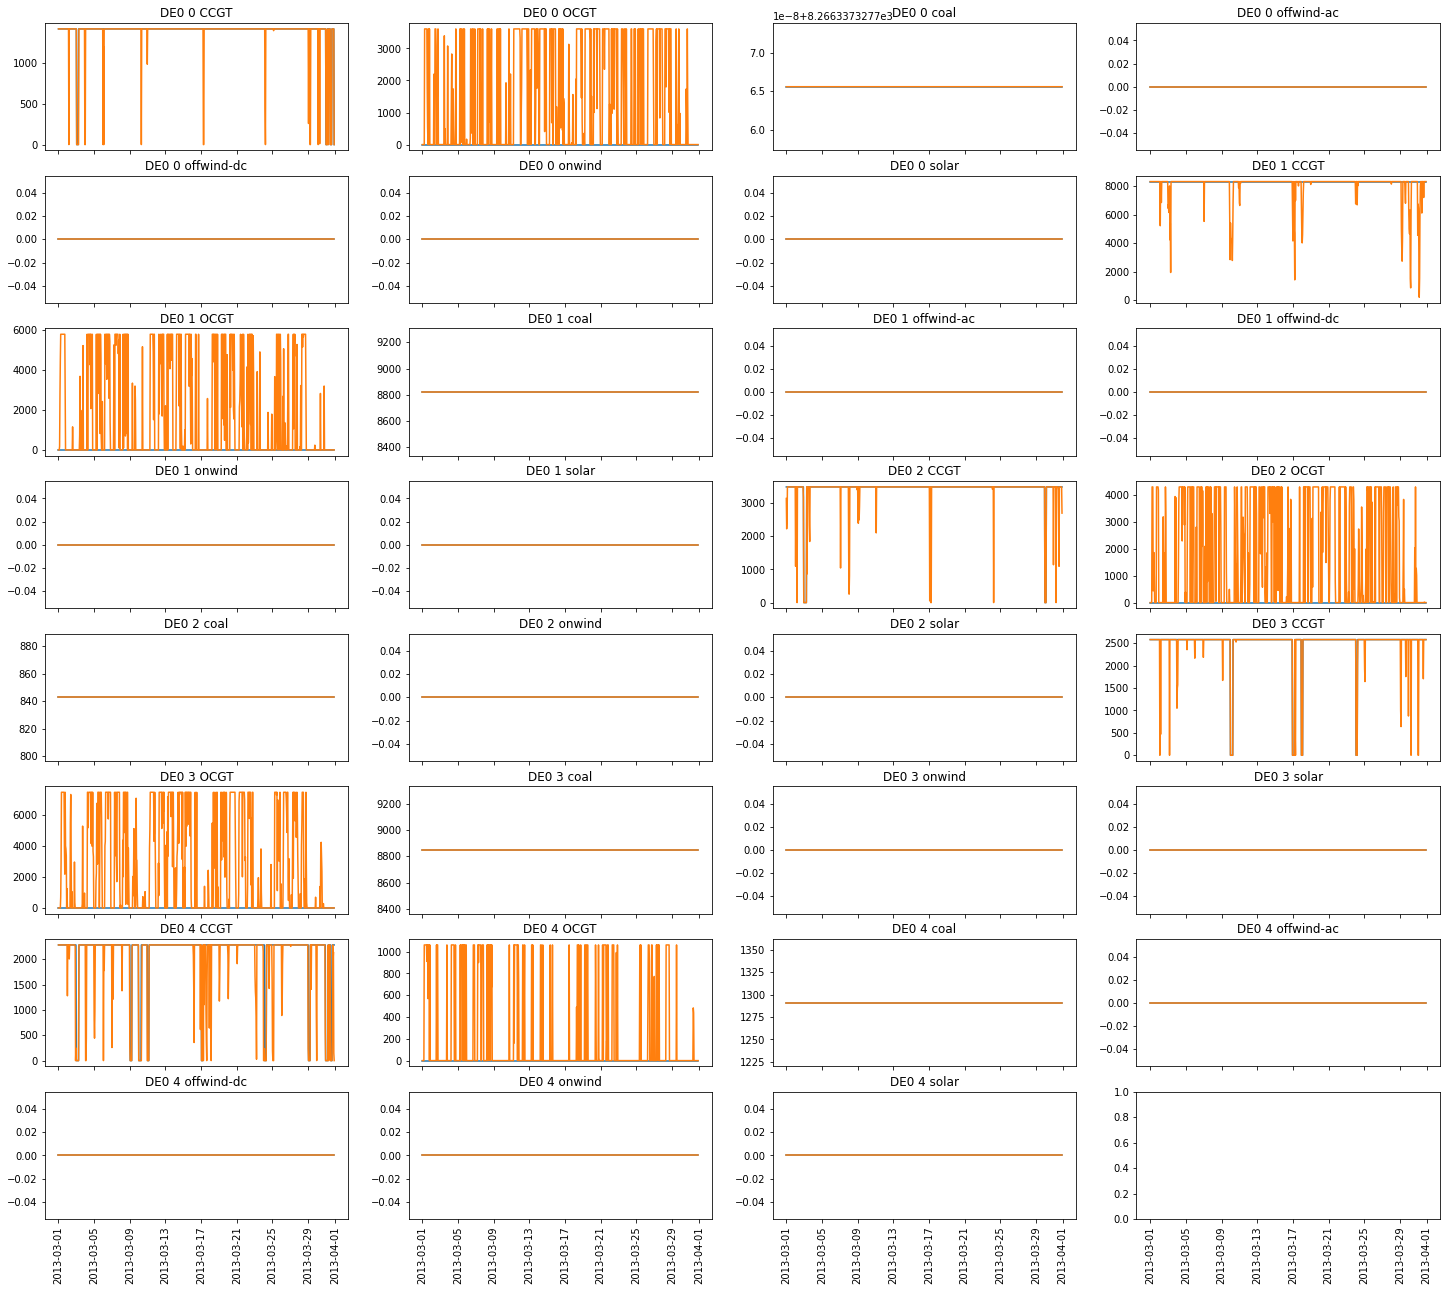

In [21]:
generateReport(test)

In [29]:
# plot the total maximum capabilities
def committedCapabilities(network, num_snapshots):
  for node in network.buses.index:
    demand = []
    for t in range(num_snapshots):
      demand.append(-generateConstant(network,node,t))
    
    generatorOutput = []
    for t in range(num_snapshots):
      generatorOutput.append(0)
      for gen in network.generators[network.generators.bus == node].index:
        if gen in network.generators_t.status.columns:
          generatorOutput[-1] += network.generators_t.status[gen].iloc[t] * getGeneratorOutput(network, gen, t)
        else:
          generatorOutput[-1] += getGeneratorOutput(network, gen, t)
    plt.plot(network.snapshots[:num_snapshots], demand, label="demand")
    plt.plot(network.snapshots[:num_snapshots], generatorOutput, label="generatorOutput")
    plt.legend(title=node)
    plt.show()
  return

def generateConstant(network, node, t):
  # the helper c_nt calculation
  c_nt = 0.
  # storage
  for i in network.storage_units[network.storage_units.bus == node].index:
    c_nt += network.storage_units_t.p[i].iloc[t]
  # lines
  for i in network.lines[network.lines.bus0 == node].index:
    c_nt -= network.lines_t.p0[i].iloc[t]
  for i in network.lines[network.lines.bus1 == node].index:
    c_nt -= network.lines_t.p1[i].iloc[t]
  #loads contribution
  for load in network.loads[network.loads.bus == node].index:
    c_nt -= network.loads_t.p_set[load].iloc[t]
  return c_nt

def getGeneratorOutput(network, gen, time):
  factor = 1.
  if(gen in network.generators_t.p_max_pu):
    factor = network.generators_t.p_max_pu[gen].iloc[time]
  return factor*network.generators.p_nom[gen]


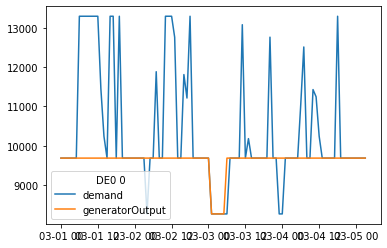

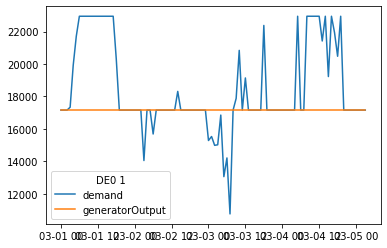

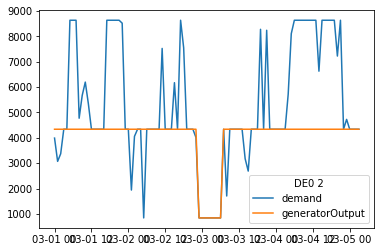

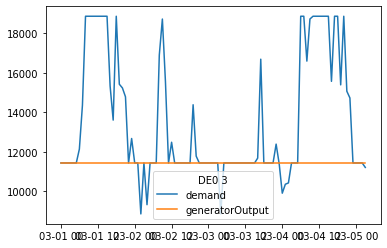

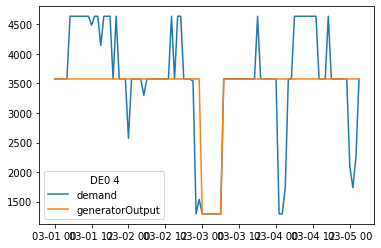

In [30]:
committedCapabilities(test, 100)